In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as opt

import eqtk

Two component receptor models

In [2]:
#L, R1, P, F

N2c=[[-1, -1, 1, 0],
     [0, -1, -1, 1]]


#L1, L2, R, P1, P2, F1, F2

N2c2l=[[-1, 0, -1, 1, 0, 0, 0],
       [0, -1, -1, 0, 1, 0, 0],
       [0, 0, -1, -1, 0, 1, 0],
       [0, 0, -1, 0, -1, 0, 1]]

Fixed inhibitor change ligand parameters

In [3]:
#no inhibitor
# 
step = 0.001
size=30

S=np.zeros((size,size))
F=np.zeros((size,size))
A=np.zeros((size,7,size))

r = 1
l1 = np.logspace(-3, 3, size)
l2 = 0.0000001


#L1, L2, R, P1, P2, F1, F2
c0 = np.zeros((size, 7))
c0[:,2] = r

fixed_c = -np.ones((size, 7))
fixed_c[:,0] = l1
fixed_c[:,1] = l2

for i,curk in enumerate(np.logspace(-3, 3, size)):
    K = [1,1,curk,100]

    c0[:,2] = r
    res = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)
    c0[:,2] = r+step/2
    res_p = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]
    c0[:,2] = r-step/2
    res_m = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

    F[:,i]=res[:,5]
    S[:,i]=(res_p-res_m)/step/res[:,5]*r
    A[:,:,i]=res

    I = F.flatten().argsort()
    Fzero=F.flatten()[I]
    Szero=S.flatten()[I]


In [4]:
# add inhibitor
step = 0.001
size=15

S=np.zeros((size,size))
F=np.zeros((size,size))
A=np.zeros((size,7,size))

r = 1
l1 = np.logspace(0, 2.5, size)
l2 = 1


#L1, L2, R, P1, P2, F1, F2
c0 = np.zeros((size, 7))
c0[:,2] = r

fixed_c = -np.ones((size, 7))
fixed_c[:,0] = l1
fixed_c[:,1] = l2

for i,curk in enumerate(np.logspace(-0.5, 3.5, size)):
    K = [1,1,curk,100]

    c0[:,2] = r
    res = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)
    c0[:,2] = r+step/2
    res_p = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]
    c0[:,2] = r-step/2
    res_m = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

    F[:,i]=res[:,5]
    S[:,i]=(res_p-res_m)/step/res[:,5]*r
    A[:,:,i]=res



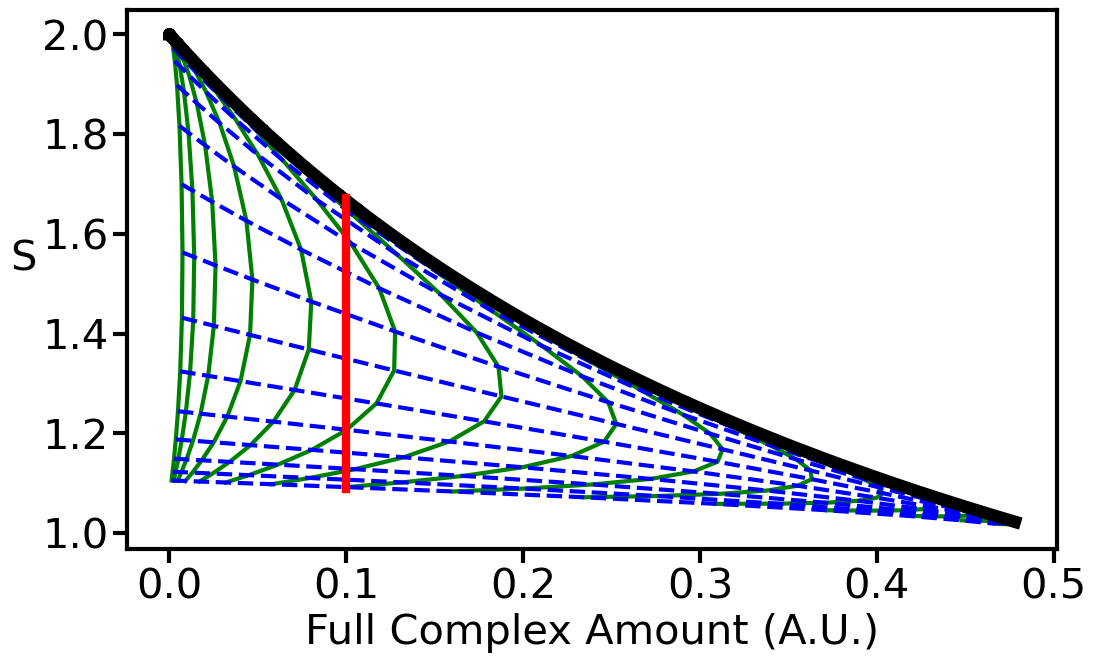

In [5]:
plt.figure(figsize=(12,7))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().tick_params(width=3, size=10)
for i in plt.gca().spines:
    plt.gca().spines[i].set_linewidth(3)

plt.xlabel('Full Complex Amount (A.U.)', fontsize=30)
plt.ylabel('S', fontsize=30, rotation=0, ha='right')



plt.plot(F,S,'-g', linewidth=3);
plt.plot(F.T,S.T,'--b', linewidth=3);

plt.plot(Fzero, Szero,'-k', linewidth=9);

plt.axvline(0.1, ymin=0.11, ymax = 0.65, c='r', linewidth='6')


In [6]:
#find the k for each ligand that gives F=0.1
r = 1
l1 = np.logspace(0, 2.5, size)
l2 = 1


def error(curk,i):
    #L1, L2, R, P1, P2, F1, F2
    c0 = [0,0,r,0,0,0,0]

    fixed_c = [l1[i], l2, -1,-1,-1,-1,-1]

    K = [1,1,curk[0],100]

    return (eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[5]-0.1)**2

ks = []
for i in range(size):
    ks.append(opt.minimize(error, 1, i).x)

ks = np.concatenate(ks)

ks

array([31.37896092, 21.77114709, 15.25477749, 11.10001548,  8.44581626,
        6.79737082,  5.99513912,  5.91295024,  6.56953435,  8.13747106,
       10.86566908, 15.52702612, 22.35824485, 32.49903533,  1.        ])

In [7]:
#calculate CV
# 
ncell=10000
r = np.random.gamma(4, 0.25, ncell)
res=np.zeros([size,ncell])

for i in range(size):

    c0 = np.zeros((ncell, 7))
    c0[:,2] = r

    fixed_c = [l1[i], l2, -1, -1, -1, -1, -1]

    K = [1,1,ks[i],100]

    res[i,:] = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

res.std(axis=1)/res.mean(axis=1)

array([0.54690131, 0.55398104, 0.56449396, 0.57969369, 0.60122948,
       0.63065362, 0.66790917, 0.71008615, 0.75075436, 0.78285528,
       0.80416814, 0.8147488 , 0.82159599, 0.82609284, 1.0472178 ])

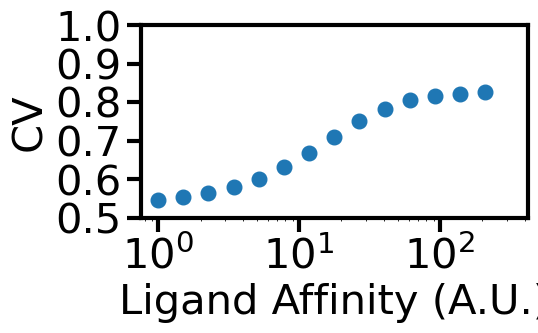

In [8]:
plt.figure(figsize=(5,2.5))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().tick_params(width=3, size=10)
for i in plt.gca().spines:
    plt.gca().spines[i].set_linewidth(3)

plt.xlabel('Ligand Affinity (A.U.)', fontsize=30)
plt.ylabel('CV', fontsize=30)

plt.ylim([0.5, 1])
plt.xscale('log')

plt.plot(l1, res.std(axis=1)/res.mean(axis=1),'.',markersize=21)




Fixed ligand change inhibitor parameters

In [9]:
step = 0.0001
size = 15

S=np.zeros((size,size))
F=np.zeros((size,size))
A=np.zeros((size,7,size))

r = 1
l1 = np.logspace(-3, 0, size)
l2 = np.logspace(-4, 0, size)

l1 = np.repeat(np.reshape(l1,[size,1]),size,1).reshape(-1)
l2 = np.repeat(np.reshape(l2,[1,size]),size,0).reshape(-1)

#L1, L2, R, P1, P2, F1, F2
c0 = np.zeros((size**2, 7))
c0[:,2] = r

fixed_c = -np.ones((size**2, 7))
fixed_c[:,0] = l1
fixed_c[:,1] = l2

K = [1,1,10,100]

c0[:,2] = r
res = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)
c0[:,2] = r+step/2
res_p = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]
c0[:,2] = r-step/2
res_m = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

F=res[:,5].reshape(size,size)
S=((res_p-res_m)/step/res[:,5]*r).reshape(size,size)
A=res.reshape(size,size,7)



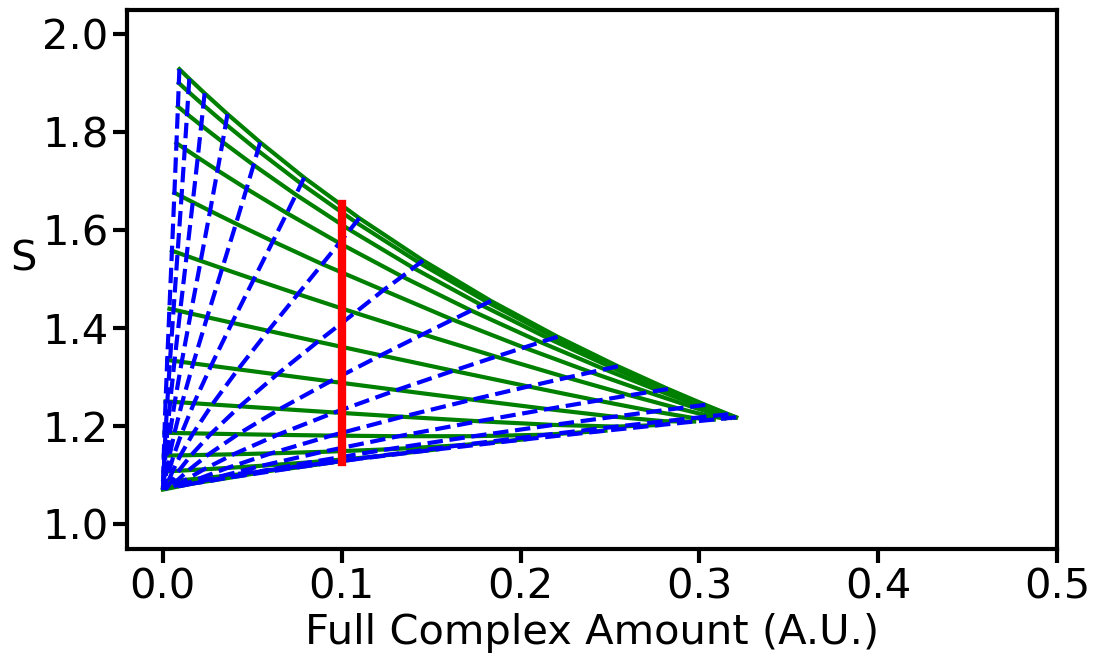

In [10]:
plt.figure(figsize=(12,7))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().tick_params(width=3, size=10)
for i in plt.gca().spines:
    plt.gca().spines[i].set_linewidth(3)

plt.xlabel('Full Complex Amount (A.U.)', fontsize=30)
plt.ylabel('S', fontsize=30, rotation=0, ha='right')

plt.xlim([-0.02, 0.5])
plt.ylim([0.95, 2.05])

plt.plot(F,S,'-g', linewidth=3);
plt.plot(F.T,S.T,'--b', linewidth=3);

#plt.plot(Fzero, Szero,'-k', linewidth=9);

plt.axvline(0.1, ymin=0.16, ymax = 0.64, c='r', linewidth='6')



In [11]:
size=15
r = 1
l2 = np.logspace(-4.5, -0.545, size)

def error(curl, i):
    #L1, L2, R, P1, P2, F1, F2
    c0 = [0,0,r,0,0,0,0]

    fixed_c = [10**curl[0], l2[i], -1,-1,-1,-1,-1]

    K = [1,1,10,100]

    return (eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[5]-0.1)**2

ls = []
x0=0
for i in range(size):
    ls.append(10**(opt.minimize(error, 0, i, bounds=[(-3,1)]).x))
    x0=opt.minimize(error, 0, i).x

ls = np.concatenate(ls)

ls

array([0.01629958, 0.01644441, 0.01673212, 0.01727265, 0.01827952,
       0.02016819, 0.02360484, 0.02979261, 0.04082821, 0.0605222 ,
       0.0961393 , 0.1616847 , 0.28498866, 0.52304838, 0.99989795])

In [12]:
#calculate CV
# 
ncell=10000
r = np.random.gamma(4, 0.25, ncell)
res=np.zeros([size,ncell])

for i in range(size):

    c0 = np.zeros((ncell, 7))
    c0[:,2] = r

    fixed_c = [ls[i], l2[i], -1, -1, -1, -1, -1]

    K = [1,1,10,100]

    res[i,:] = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]


res.std(axis=1)/res.mean(axis=1)

array([0.82017596, 0.81770224, 0.81308079, 0.80486648, 0.79105387,
       0.76962735, 0.74027303, 0.70528573, 0.66908081, 0.63596844,
       0.6086009 , 0.58796618, 0.57407198, 0.56668546, 0.56593138])

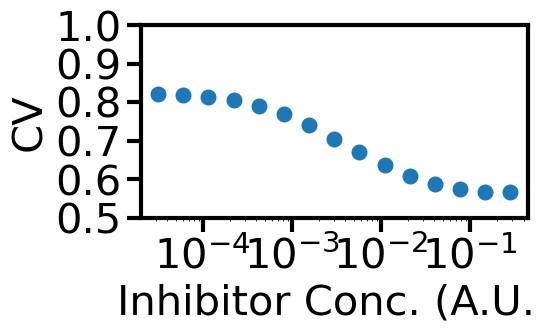

In [13]:
plt.figure(figsize=(5,2.5))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().tick_params(width=3, size=10)
for i in plt.gca().spines:
    plt.gca().spines[i].set_linewidth(3)

plt.xlabel('Inhibitor Conc. (A.U.)', fontsize=30)
plt.ylabel('CV', fontsize=30)

plt.ylim([0.5, 1])
plt.xscale('log')

plt.plot(l2, res.std(axis=1)/res.mean(axis=1),'.', markersize=21)

